# Physics 113: Problem Set 2
## Submit notebook to Canvas by April 30, 2023 17:00 PDT

## Question 1: Optimization with Unknown Gradient (3 points)

In class, we saw how to use an optimizer to find the minimum of a given function. But in our examples, the function and its gradient was known. What can we do if the analytical form for our function -- and therefore an analytical form for its gradient -- is unknown? Here we will explore one possible method.

Let's begin by importing the necessary libraries.

In [12]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

For simplicity, we'll again use the Rosenbrock function, but we won't allow ourselves to take its gradient.

In [13]:
def rosen(x, a=1, b=5):
    return (a-x[0])**2 + b*(x[1] - x[0]**2)**2

Let's take a look at the function:

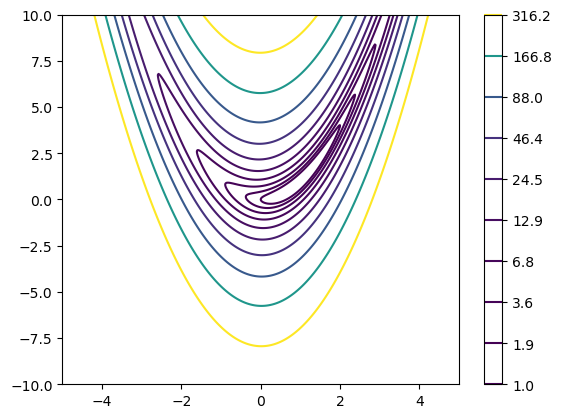

In [14]:
# Generate points
xs, ys = np.meshgrid(np.linspace(-5, 5, 500),
                     np.linspace(-10, 10, 500))
zs = rosen([xs, ys])

# Plot
fig, ax = plt.subplots(1, 1)
cs = ax.contour(xs, ys, zs,levels=np.logspace(0,2.5,10))
fig.colorbar(cs)

Since we don't know the gradient at any given point, we could imagine *estimating* it using a Monte Carlo method. Let's pick N random points a distance lr (our learning rate) from it and use these samples to estimate the gradient, then pick whichever one points most towards the minimum (is most negative).

Complete the function below to implement this method.

In [15]:
def Optimizer(f, x, N, lr):
    '''
    Optimization function which estimates the gradient.
    f: Some function to minimize
    x: Initial value of the function
    N: Number of points to sample in finding the gradient
    lr: Distance of each jump
    '''
    x_history = []
    n_steps = 0

    dim = x.shape[0]

    #insert termination condition, small function change or small gradient
    for _ in tqdm(range(10000)):
        gradient = np.inf
        
        if np.linalg.norm(gradient) <= 1e-3:
            break
        # Keep track of x points to plot
        x_history.append(x)
        
        # Sample many points
        for i in range(N):
            # Sample a random direction isotropically on the unit sphere in R^dim
            d = np.random.normal(size = dim)
            d /= np.linalg.norm(d)
            d *= lr
            gradient = min(gradient, (f(x + d) - f(x))/lr)
        
        # Update x
        x = x + d
        n_steps += 1
        
    return x, f(x), np.array(x_history)

Let's take a look at how this fares when varying the number of points sampled. Plot x_history for a range of values of N and a range of learning rates. What do you expect for N=1? How about for N=100? What do you expect for small and large learning rates?

100%|██████████| 10000/10000 [00:23<00:00, 427.34it/s]


Minimum value of the function is 1.009564755800325 at [-0.00055042  0.04114304]


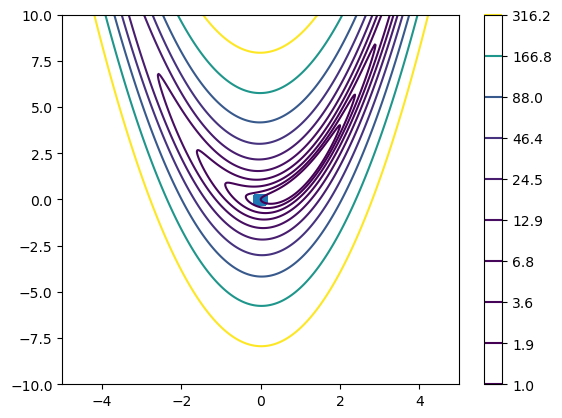

In [26]:
x, f, x_history = Optimizer(rosen, np.array([0, 0]), 100, 1e-3)
print("Minimum value of the function is", f, "at", x)
fig, ax = plt.subplots(1, 1)
cs = ax.contour(xs, ys, zs,levels=np.logspace(0,2.5,10))
ax.scatter(x_history[:,0], x_history[:,1], marker = ",")
fig.colorbar(cs)

100%|██████████| 10000/10000 [00:23<00:00, 432.23it/s]


Minimum value of the function is 0.9128580024529573 at [0.39580758 0.48766501]


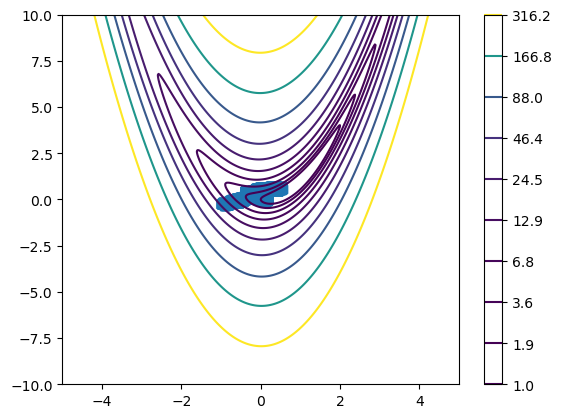

In [27]:
x, f, x_history = Optimizer(rosen, np.array([0, 0]), 100, 1e-2)
print("Minimum value of the function is", f, "at", x)
fig, ax = plt.subplots(1, 1)
cs = ax.contour(xs, ys, zs,levels=np.logspace(0,2.5,10))
ax.scatter(x_history[:,0], x_history[:,1], marker = ",")
fig.colorbar(cs)

**TO DO: Describe what you see**

In [ ]:
''' TO DO: plot contour and x_history for a range of lr '''

**TO DO: Describe what you see**

## Question 2: Constraining the Neutron Star Equation of State (7 points)

We've recently discussed how to integrate ODEs using the 4th Order Runge-Kutta
Method in class. In this question we are going to couple this with the interpolation
to model the effect of binary neutron stars during the early stages of a merger!

The neutron star equation of state (EOS) is a fundamental problem in astrophysics that has important implications for our understanding of the nature of matter under extreme conditions, as well as for the dynamics of compact astrophysical objects such as neutron stars and black holes. Neutron stars are some of the densest objects in the universe, with core densities that can reach several times that of nuclear saturation density. Understanding the EOS for neutron stars provides insight into the behavior of matter at these extreme densities, which cannot be directly probed in terrestrial laboratories.

In [ ]:
import pickle

from copy import copy 
from pathlib import Path 
from tqdm.auto import tqdm
from typing import Dict, List, Optional
from dataclasses import dataclass, field, InitVar

from astropy import units as u
from astropy import constants as const 

from scipy.integrate import solve_ivp
from scipy.special import factorial2, lpmn, lqmn


### The Neutron Star Equation of State 

The EoS describes the relationship between the pressure, density, and temperature of the matter inside a neutron star. Constraining the EOS is crucial because it impacts a variety of observables related to neutron stars, such as their mass, radius, and tidal deformability. These quantities can provide valuable information on the composition, structure, and properties of neutron stars, as well as the fundamental forces and particles governing their behavior.

For simplicity, we're just going to focus on the density $\epsilon$ and pressure 
$P$, making our EoS model the following form $P(\epsilon)$. 

## <font color='red'>WARNING!!

Before running the any of the computation below it is very import that we normalize or units or else 
we'll run into a slew of problems! A good relativist tries to work with units 
where $G=c=1$ because it allows the units of each value to be related to some exponential 
scaling of length (i.e., $L^n$ where $n \in \mathbb Z$). 

Feel free to use the `from astropy import units as u` and `from astropy import constants as const` to help set this up correctly, and find some units of length that make your computation feasible. 

For the datasets used in this assignment, they've already been preprocessed to have units of $\frac{{\rm g}}{{\rm cm}^3}$, so please take that into consideration.

There are some hints throughout the notebook to help get you started. 

In [ ]:
eos_factor = ...

Let's create our EoS Model!

In the equation of state model below please fill out the empty functions with an 
iterpolation scheme to produce the correct pressure $P$, density $\epsilon$, and 
squared sound speed $c_{s}^{2}$. Where 

> $$c_{s} = \sqrt{\frac{dP}{d\epsilon}}$$

Note that there is a class attribute that stores $\log_{10}P$ and $\log_{10}\epsilon$
values in the case you need to use them. 

In [ ]:
@dataclass
class EquationOfState: 
    name: str 
    pressures: np.ndarray
    densities: np.ndarray
    speed_of_sounds: np.ndarray = field(init=False)

    central_densities: list = field(init=False)
    central_pressures: list = field(init=False)
    central_cutoff: float = field(default=11.0)

    factor: InitVar[Optional[float]] = field(default=None)

    def __post_init__(self, factor: Optional[float] = None) -> None:
        central_mask = np.log10(self.pressures) >= self.central_cutoff
        
        if factor is not None:
            # TODO: Place the correct units in to_value
            convert = lambda x: (factor * x * u.g / u.cm**3).to_value(...)
            self.densities = convert(self.densities)
            self.pressures = convert(self.pressures)
        # TODO: Compute the speed of sound, c_s
        self.speed_of_sounds = ...

        self.central_densities = list(self.densities[central_mask])
        self.central_pressures = list(self.pressures[central_mask])

        self.log_densities = np.log10(self.densities)
        self.log_pressures = np.log10(self.pressures)

    def __repr__(self) -> str:
        return f"{self.name} Equation of State"

    @classmethod
    def from_data_files(cls, path: Path, factor: Optional[float]=None) -> dict: 
        eos_data = pickle.load(open(path.as_posix(), 'rb'))
        return {
            key : cls(key, eos[:, 0], eos[:, 1], factor=factor)
            for key, eos in eos_data.items()
        }
    
    def get_density(self, pressure: float) -> float:
        return ...
    
    def get_pressure(self, density: float) -> float:
        return ...
    
    def get_speed_of_sound(self, pressure: float) -> float:
        return ...
    
    def plot(self, ax: Optional[plt.Axes]=None) -> None:
        inverse_factor = ...
        convert = lambda x: ((x /u.km**2).cgs * inverse_factor)
        densities, pressures = convert(self.densities), convert(self.pressures)

        if ax is not None:
            ax.loglog(densities, pressures, label=self.name)
        else:
            _, ax = plt.subplots(figsize=(8, 6))
            ax.loglog(densities, pressures)
            ax.set_xlabel(r"Density $\log_{10}\rho$, $[g/cm^{-3}]$", fontsize=14)
            ax.set_ylabel(r"Pressure, $\log_{10}P$, $[g/cm^{-3}]$", fontsize=14)
            ax.set_title(self.__repr__(), fontsize=16)
            plt.show()

In [ ]:
# Load equation of state 
data_path = Path(Path.cwd(), 'eos_data.pkl')
eos_data = EquationOfState.from_data_files(data_path, factor=eos_factor)
print(f"We have {len(eos_data)} different equation of states in total.")

But we'll focus on these six to start

In [ ]:
target_datasets = ["gs1", "gs2", "H4", "H5", "H6", "H7"]

Let's plot them to see what they look like!

In [ ]:
def plot_equation_of_states(data: dict, datasets: List[str]) -> None:
    _, ax = plt.subplots(figsize=(8, 6))

    for dataset in datasets:
        eos = data[dataset]
        eos.plot(ax)

    ax.set_xlabel(r"Density $\log_{10}\rho$, $[g/cm^{-3}]$", fontsize=14)
    ax.set_ylabel(r"Pressure, $\log_{10}P$, $[g/cm^{-3}]$", fontsize=14)
    ax.set_title("Equation of States", fontsize=16)
    ax.legend()
    plt.show()

plot_equation_of_states(eos_data, target_datasets)

Any thoughts on what is going on? What area of this curve correspond to the 
interior and exterior regions of the star?

One way to constrain the neutron star EoS is through the measurement of their mass $M$ and radius $R$. Observations of binary neutron star systems or neutron stars in binary systems with other types of stars can provide estimates of their masses through the analysis of their orbital dynamics. On the other hand, the radius can be estimated through X-ray observations of neutron stars, by modeling their thermal emission and exploiting the relationship between the observed X-ray flux and the surface area of the star. By comparing these observed mass-radius relations with theoretical models, we can place constraints on the EoS and better understand the underlying physics.

Tidal deformability, $\Lambda$ is another important property that can help us constrain the neutron star EoS. Tidal deformability refers to the degree to which a neutron star is deformed under the influence of an external gravitational field, such as that of a companion star in a binary system. This property is closely related to the star's internal structure and can be probed through the observation of gravitational waves emitted during the inspiral and merger of compact binary systems, like those composed of two neutron stars or a neutron star and a black hole. The detection and analysis of gravitational wave signals can provide estimates of the tidal deformability of the neutron stars involved in the merger, which can be compared with theoretical models to further constrain the EoS.

Now we're going to set up our neutron star!

In order to help make computation a bit easier, we need to fill out a couple of 
helper functions. In the model below fill out functions regarding the star's 
compactness 

> $$\mathcal{C} = \frac{M}{R}$$

the $g_{rr}$ Schwarzschild metric term

> $$g_{rr} = \left[1 - \frac{2M}{R} \right]^{-1}$$

and tidal deformability

> $$\Lambda_{\ell} = \frac{-1}{(2\ell -1)!!}\left. \frac{\hat{P}_{\ell 2}^{\prime}(x)-\mathcal{C}Y_{\ell}\hat{P}_{\ell 2}(x)}{\hat{Q}_{\ell 2}^{\prime}(x)-\mathcal{C}Y_{\ell}\hat{Q}_{\ell 2}(x)} \right|_{x = \mathcal{C}^{-1}-1}$$

where $Y_{\ell}$ is the fully evolved tidal perturbation that will be computed 
below and $\hat{P}_{\ell 2}(x),\hat{Q}_{\ell 2}(x)$ are the associated Legendre 
polynomials of the first and second kind. Since gravitational waves are produced 
by accelerating quadrupole moments, we will set $\ell = 2$.

There are some helper functions that have been imported from scipy to help 
compute some of these values (including the double factorial term). 

Similar to the EoS model we need to implement a conversion factor in the 
`get_mass_radius` function in order to help get correct units for our final 
output.

In [ ]:
@dataclass
class NeutronStar: 
    density: float
    pressure: float
    eos: EquationOfState
    mass: float = field(init=False)
    radius: float = field(default=0.0)

    multipole_order: int = field(default=2)
    tidal_pertubation: float = field(init=False)

    def __post_init__(self) -> None: 
        self.mass = 4.0 * np.pi * self.radius**3 * self.density / 3.0
        self.tidal_pertubation = self.multipole_order

    def __repr__(self) -> str:
        mass, radius = self.get_mass_radius
        return f"NeutronStar(mass={mass:.2f} Msun, radius={radius:.2f} km)"

    
    def evolve(self, properties: np.ndarray, dr: float) -> NeutronStar:
        pressure = self.pressure + properties[0]
        density = self.eos.get_density(pressure)
        new_radius = self.radius + dr
        new_star = NeutronStar(density, pressure, self.eos, radius=new_radius) 
        new_star.mass = self.mass + properties[1]
        new_star.tidal_perturbation = self.tidal_pertubation + properties[2]
        return new_star

    
    @property
    def compactness(self) -> float:
        return ...
    
    @property
    def grr(self) -> float: 
        return ...
    
    @property
    def speed_of_sound(self) -> float:
        return ...

    @property
    def tidal_deformability(self) -> float:
        l, C, Y = ..., ..., ...
        x = ...
        (Pmn_x, Pmn_d_x), (Qmn_x, Qmn_d_x) = lpmn(..., ..., ...), lqmn(..., ..., ...)
        Pl2_x, Pl2_d_x = Pmn_x[..., ...], Pmn_d_x[..., ...]
        Ql2_x, Ql2_d_x = Qmn_x[..., ...], Qmn_d_x[..., ...]
        # Use factorial2 to compute the double factorial
        return ... 
    
    @property
    def get_mass_radius(self) -> tuple:
        inverse_factor = ...
        # TODO: Place the correct units in convert using astropy.units 
        # Hint: It should be a length unit... 
        convert = lambda x: (inverse_factor * x * ...).to_value("Msun")
        return convert(self.mass), self.radius

Now we need to setup our system of ODEs!

Implement the following equations below

> $$\frac{dP}{dr} = -\frac{\left(\epsilon+p\right)\left(m+4\pi r^{3}p\right)}{r \left(r - 2m \right)}$$
> $$\frac{dm}{dr} = 4\pi r^{2} \epsilon$$
> $$r\frac{dy_{\ell}}{dr} + y_{\ell}\left[y_{\ell}-1\right] + A(r)y_{\ell} - B_{\ell}(r) = 0$$

where 

> $$A(r) = 2g_{rr}\left[1-\frac{3m}{r}-2\pi r^{2}(\epsilon+3p)\right]$$
> $$B_{\ell}(r) = g_{rr}\left[\ell(\ell+1)-4\pi r^{2}(\epsilon+3p)(3+c_{s}^{-2})\right]$$

In [ ]:
def pressure_diff(ns: NeutronStar) -> float:
    dPdr = ...
    return dPdr

def mass_diff(ns: NeutronStar) -> float:
    dmdr = ... 
    return dmdr 

def tidal_diff(ns: NeutronStar) -> float:
    dyl_dr = ...
    return dyl_dr

def evolve_step(radius: float, ns: NeutronStar) -> np.ndarray[float]:
    if (ns.radius == 0.0): return np.zeros(3)
    return np.array([pressure_diff(ns), mass_diff(ns), tidal_diff(ns)])

Almost there !

Implement the 4th-Order Runge-Kutta method in the `stepRK4` method. Please use 
`evolve_step` function to perform proper updates.

In [ ]:
class StarSolver: 
    def __init__(self, eos: EquationOfState, dr: float = 0.01) -> None:
        self.name = eos.name
        self.dr = dr

        # Initialize the stars
        centrals = zip(eos.central_densities, eos.central_pressures)
        self.stars = [
            NeutronStar(pressure=pressure, density=density, eos=eos) 
            for density, pressure in centrals
        ]

        print(f"Initialized {len(self.stars)} stars.")

        # Define Cutoff
        self.cutoff_pressure = max(0, min(eos.pressures))

    def __repr__(self) -> str:
        return f"StarSolver(name={self.name})"

    def solve(self) -> List[NeutronStar]:
        evolved_stars = []
        for ns in tqdm(self.stars, desc="Evolving Neutron Stars"):
            while (ns.pressure > self.cutoff_pressure):
                evolved_ns = self.stepRK4(ns)
                ns = evolved_ns
            evolved_stars.append(ns)
        return evolved_stars
    
    def stepRK4(self, ns: NeutronStar) -> NeutronStar:
        r, ns_copy = copy(ns.radius), copy(ns)
        # TODO: Implement the RK4 method
        return ns.evolve(..., ...)



In [ ]:
solvers = {dataset : StarSolver(eos_data[dataset]) for dataset in target_datasets}
solvers 

In [ ]:
# This may take a couple of minutes
evolved_stars = {dataset : solver.solve() for dataset, solver in solvers.items()}

In [ ]:
def plot_evolved_stars(evolved_stars: Dict[str, List[NeutronStar]]) -> None:
    ''' Plot Mass-Radii and Tidal Deformability as 1x2 subplots'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    for key, stars in evolved_stars.items():
        # Mass-Radii Plot 
        masses, radii = zip(*[star.get_mass_radius for star in stars])
        ax1.plot(radii, masses, "o", label=key)
        ax1.set_xlabel(r"Radius, $R$ $[km]$", fontsize=14)
        ax1.set_ylabel(r"Mass, $M$  $[M_{\odot}]$", fontsize=14)
        ax1.tick_params(axis='both', which='major', labelsize=12)

        # Tidal Deformability Plot 
        compactness, deformability = zip(*[
            (star.compactness, star.tidal_deformability) for star in stars
        ])
        ax2.plot(compactness, deformability, "o", label=key)
        ax2.set_xlabel(r"Compactness, $\mathcal{C}$", fontsize=14)
        ax2.set_ylabel(r"Tidal Deformability, $\Lambda$", fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        ax2.set_ylim(0, 1200)  # Set upper limit on the y-axis

    # Position the legend outside of the right subplot
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    fig.suptitle("Mass-Radius and Tidal Deformabilities", fontsize=18)
    plt.show()


In [ ]:
plot_evolved_stars(evolved_stars)

Congrats! You've finished! Feel free to do so some exploring be changing the step
size of the solver or potentially adding additional integration step methods to 
`StarSolver` to see how your results and performance may change. 